In [1]:
import nltk
nltk.download('cess_esp')
from nltk.corpus import cess_esp
import matplotlib.pyplot as plt
import numpy as np
from nltk import hmm
import math
from nltk.tag import tnt, AffixTagger, brill_trainer, brill, UnigramTagger, PerceptronTagger

nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package cess_esp to /root/nltk_data...
[nltk_data]   Unzipping corpora/cess_esp.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

# Funciones auxiliares

In [2]:
def mean(lst):
  return sum(lst) / len(lst)

def elements_block(data, blocks=10):
  return math.ceil(data.shape[0] / blocks)

def confidence_cross_validation(accuracies, blocks=10):
  accuracy = mean(accuracies)

  result = 0
  for i in accuracies:
    result += (i - accuracy) ** 2

  return accuracy, 1.96 * math.sqrt((result / len(accuracies)) / blocks)

def cross_validation(data, train_evaluate_function, blocks=10):
  elements_per_block = elements_block(data, blocks=blocks)
  accuracies = []

  for i in range(blocks):
    test_indexes = set([i for i in range(i * elements_per_block, (i + 1) * elements_per_block)])
    training_indexes = set([i for i in range(data.shape[0])])
    training_indexes = training_indexes - test_indexes

    training_items = data[list(training_indexes)]
    test_items = data[list(test_indexes)]

    accuracies.append(train_evaluate_function(training_items, test_items))
  return accuracies

def confidence_error(p, n):
  return 1.95 * np.sqrt(p * (1 - p) / n)

def plot_accuracies(accuracies, data, blocks=10, title="", xlabel='Block', style='ro', min_value=0.8, max_value=1.0, tic=None):
  elements_per_block = math.ceil(data.shape[0] / blocks)

  block_iterator = range(blocks)
  if tic is not None:
    tic = [confidence_error(accuracies[i], elements_per_block) for i in block_iterator]

  plt.plot(block_iterator, accuracies, style)

  plt.xlabel(xlabel)
  plt.ylabel('Accuracy')
  plt.title(title)

  axes = plt.gca()
  axes.set_ylim([min_value, max_value])

  plt.errorbar(block_iterator, accuracies, yerr=tic, linestyle='None')

  plt.show()

def reduce_corpus(list_pairs):
  result = [None] * len(list_pairs)
  for index, sentence in enumerate(list_pairs):
    sentence_result = []
    for word in sentence:
      if word[0] == u'*0*':
        continue
      value = 2
      if word[1].startswith('v') or word[1].startswith('F'):
        value = 3
      sentence_result.append((word[0], word[1][:value]))
    result[index] = sentence_result
  return np.asarray(result, dtype=object)

def load_corpus():
  return np.asarray(cess_esp.tagged_sents(), dtype=object)

In [3]:
complete_corpus = load_corpus()
reduced_corpus = reduce_corpus(complete_corpus)

np.random.seed(23)

# Tarea 1

Evaluación del etiquetador ‘hmm’ sobre el corpus ‘cess-esp’ utilizando el juego de categorías completo y reducido

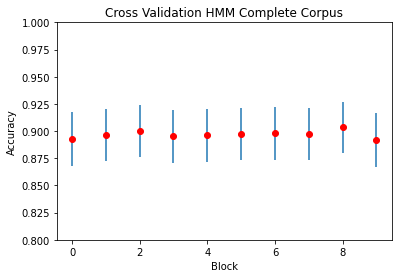

Accuracy: 0.8967908445916134 -> [0.89% - 0.90%]
[0.8926417986714359, 0.8965181771633385, 0.8996741384417892, 0.8953981635611877, 0.8961875879995668, 0.8972847821511261, 0.8977936237275874, 0.8972862263184844, 0.9036292802952635, 0.8914946675863533]


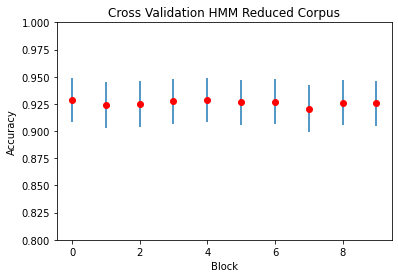

Accuracy: 0.9259176476742803 -> [0.92% - 0.93%]
[0.928799659175631, 0.9240241026984543, 0.9247163446795461, 0.9274717218265606, 0.9285408414516647, 0.9263770903456751, 0.9268707482993197, 0.9207223428480644, 0.9260450160771704, 0.9256086093407168]


In [9]:
def training_evaluate_hmm(training, test):
  hmm_instance = hmm.HiddenMarkovModelTagger.train(training)
  return hmm_instance.evaluate(test)

complete_corpus_shuffled = complete_corpus.copy()
reduced_corpus_shuffled = reduced_corpus.copy()

np.random.shuffle(complete_corpus_shuffled)
np.random.shuffle(reduced_corpus_shuffled)

hmm_shuffled_accuracies = cross_validation(complete_corpus_shuffled, training_evaluate_hmm)

plot_accuracies(hmm_shuffled_accuracies, complete_corpus_shuffled, title="Cross Validation HMM Complete Corpus", tic=True)
accuracy, confidence = confidence_cross_validation(hmm_shuffled_accuracies)
print(f"Accuracy: {accuracy} -> [{accuracy - confidence:3.2f}% - {accuracy + confidence:3.2f}%]")
print(hmm_shuffled_accuracies)

hmm_shuffled_accuracies = cross_validation(reduced_corpus_shuffled, training_evaluate_hmm)

plot_accuracies(hmm_shuffled_accuracies, reduced_corpus_shuffled, title="Cross Validation HMM Reduced Corpus", tic=True)
accuracy, confidence = confidence_cross_validation(hmm_shuffled_accuracies)
print(f"Accuracy: {accuracy} -> [{accuracy - confidence:3.2f}% - {accuracy + confidence:3.2f}%]")
print(hmm_shuffled_accuracies)

# Tarea 2

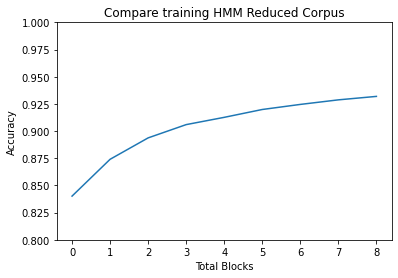

In [5]:
def evaluation_parts(data, blocks=10):
  elements_per_block = math.ceil(data.shape[0] / blocks)
  accuracies = []
  test_indexes = set([i for i in range(elements_per_block)])
  test_items = data[list(test_indexes)]

  for i in range(1, blocks):
    training_indexes = set([i for i in range(1 * elements_per_block, (i + 1) * elements_per_block)])
    training_items = data[list(training_indexes)]

    hmm_instance = hmm.HiddenMarkovModelTagger.train(training_items)

    accuracies.append(hmm_instance.evaluate(test_items))
  
  return accuracies

reduced_corpus_shuffled = reduced_corpus.copy()

np.random.shuffle(reduced_corpus_shuffled)

hmm_shuffled_accuracies = evaluation_parts(reduced_corpus_shuffled)

plot_accuracies(hmm_shuffled_accuracies, reduced_corpus_shuffled, title="Compare training HMM Reduced Corpus", xlabel='Total Blocks', blocks=9, style='-')

# Tarea 3

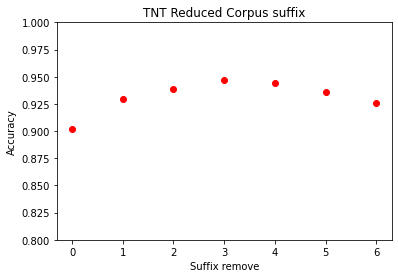

Accuracy: 0.9318834303685843 -> [0.92% - 0.94%]
Accuracy: 0.9346240697652577 -> [0.93% - 0.94%]


In [6]:
reduced_corpus_shuffled = reduced_corpus.copy()

np.random.shuffle(reduced_corpus_shuffled)

accuracies = []
for suffix in range(7):
  def training_evaluate(training, test):
    tnt_instance = tnt.TnT(unk=AffixTagger(list(training), affix_length=-suffix), Trained=True)
    tnt_instance.train(training)
    return tnt_instance.evaluate(test)

  shuffled_accuracies = cross_validation(reduced_corpus_shuffled, training_evaluate)
  accuracies.append(mean(shuffled_accuracies))

plot_accuracies(accuracies, reduced_corpus_shuffled, title=f"TNT Reduced Corpus suffix", xlabel='Suffix remove', blocks=7, min_value=0.8)
accuracy, confidence = confidence_cross_validation(accuracies)
print(f"Accuracy: {accuracy} -> [{accuracy - confidence:3.2f}% - {accuracy + confidence:3.2f}%]")

complete_corpus_shuffled = complete_corpus.copy()

np.random.shuffle(complete_corpus_shuffled)

def training_evaluate(training, test):
    tnt_instance = tnt.TnT(unk=AffixTagger(list(training), affix_length=-3), Trained=True)
    tnt_instance.train(training)
    return tnt_instance.evaluate(test)

shuffled_accuracies = cross_validation(complete_corpus_shuffled, training_evaluate)
accuracy, confidence = confidence_cross_validation(shuffled_accuracies)
print(f"Accuracy: {accuracy} -> [{accuracy - confidence:3.2f}% - {accuracy + confidence:3.2f}%]")

# Tarea 4

## Brill

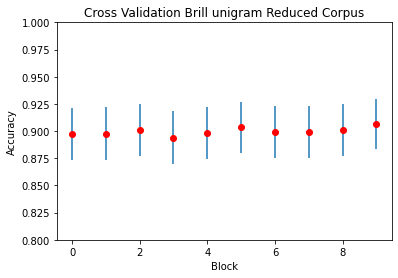

Accuracy: 0.8997440575376261 -> [0.90% - 0.90%]


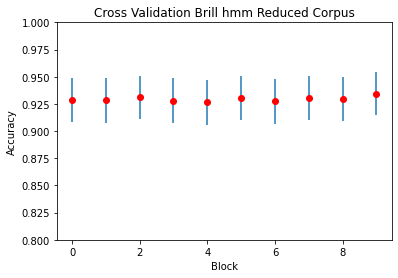

Accuracy: 0.9294133429521043 -> [0.93% - 0.93%]


In [7]:
def training_evaluate_unigram(training, test):
  trainer = brill_trainer.BrillTaggerTrainer(UnigramTagger(list(training)), brill.brill24(), deterministic=True)
  trainer = trainer.train(training)
  return trainer.evaluate(test)

def training_evaluate_hmm(training, test):
  trainer = brill_trainer.BrillTaggerTrainer(hmm.HiddenMarkovModelTagger.train(training), brill.brill24(), deterministic=True)
  tagger1 = trainer.train(training)
  return tagger1.evaluate(test)

reduced_corpus_shuffled = reduced_corpus.copy()

np.random.shuffle(reduced_corpus_shuffled)

shuffled_accuracies = cross_validation(reduced_corpus_shuffled, training_evaluate_unigram)
plot_accuracies(shuffled_accuracies, reduced_corpus_shuffled, title="Cross Validation Brill unigram Reduced Corpus", tic=True)

accuracy, confidence = confidence_cross_validation(shuffled_accuracies)
print(f"Accuracy: {accuracy} -> [{accuracy - confidence:3.2f}% - {accuracy + confidence:3.2f}%]")

shuffled_accuracies = cross_validation(reduced_corpus_shuffled, training_evaluate_hmm)
plot_accuracies(shuffled_accuracies, reduced_corpus_shuffled, title="Cross Validation Brill hmm Reduced Corpus", tic=True)

accuracy, confidence = confidence_cross_validation(shuffled_accuracies)
print(f"Accuracy: {accuracy} -> [{accuracy - confidence:3.2f}% - {accuracy + confidence:3.2f}%]")

## Perceptron

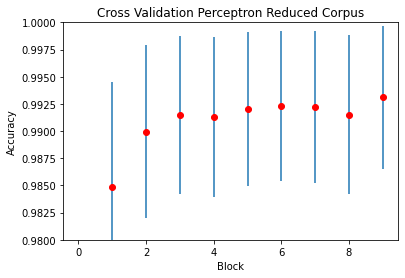

Accuracy: 0.9879509218739946 -> [0.98% - 0.99%]


In [8]:
def training_evaluate_perceptron(training, test):
  trainer = PerceptronTagger()
  trainer.train(training)
  return trainer.evaluate(test)

reduced_corpus_shuffled = reduced_corpus.copy()

np.random.shuffle(reduced_corpus_shuffled)

shuffled_accuracies = cross_validation(reduced_corpus_shuffled, training_evaluate_perceptron)
plot_accuracies(shuffled_accuracies, reduced_corpus_shuffled, title="Cross Validation Perceptron Reduced Corpus", tic=True, min_value=0.98)

accuracy, confidence = confidence_cross_validation(shuffled_accuracies)
print(f"Accuracy: {accuracy} -> [{accuracy - confidence:3.2f}% - {accuracy + confidence:3.2f}%]")